In [100]:
import os

import pandas as pd
import numpy as np
import mlflow
from mlflow.tracking import MlflowClient

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from itertools import product
import joblib
from dotenv import load_dotenv

In [80]:
path = '/Users/binit/PycharmProjects/ML_AIT_A3/pythonProject/ProjectA3/Data/Out_287.csv'

In [81]:
df = pd.read_csv(path)
df = df.drop(columns=['Unnamed: 0'])

In [135]:
df.head(5)

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,mileage,engine,max_power,price_category_bins
0,BMW,2017,3200000,13663,Diesel,Dealer,Automatic,22.69,1995.0,190.00,3
1,BMW,2012,900000,155000,Diesel,Individual,Automatic,16.07,1995.0,181.00,3
2,BMW,2017,2950000,39000,Diesel,Dealer,Automatic,19.59,1995.0,187.74,3
3,BMW,2009,1100000,60000,Diesel,Individual,Automatic,16.07,1995.0,181.00,3
4,BMW,2012,1100000,80000,Diesel,Individual,Automatic,16.07,1995.0,181.00,3


In [83]:
df.describe()

,year,selling_price,km_driven,owner,mileage,engine,max_power,seats
count,6663.000000,6.663000e+03,6663.000000,6663.000000,6663.000000,6663.000000,6663.000000,6663.000000
mean,2013.588924,5.243708e+05,73044.716644,1.499475,19.508243,1433.287858,87.871039,5.442593
std,3.898769,5.090416e+05,48214.360087,0.733034,3.913635,492.908839,31.622824,0.988814
min,1994.000000,2.999900e+04,1000.000000,1.000000,9.000000,624.000000,34.200000,4.000000
25%,2011.000000,2.500000e+05,38000.000000,1.000000,16.800000,1197.000000,68.000000,5.000000
50%,2014.000000,4.200000e+05,69123.000000,1.000000,19.500000,1248.000000,81.860000,5.000000
75%,2017.000000,6.500000e+05,100000.000000,2.000000,22.540000,1498.000000,100.000000,5.000000
max,2020.000000,1.000000e+07,500000.000000,4.000000,42.000000,3604.000000,400.000000,14.000000


In [84]:
columns_drop = ['seats','owner']
df.drop(columns=columns_drop, inplace=True)

In [85]:
# Binning is applied to categorize car prices:
selling_price = df['selling_price']  # Use your dataset
bins = [0, 250000, 500000, 750000, df['selling_price'].max()]  # Define bin edges
labels = [0, 1, 2, 3]  # Assign category labels

df['price_category_bins'] = pd.cut(df['selling_price'], bins=bins, labels=labels, include_lowest=True)
print(df['price_category_bins'].value_counts())

price_category_bins
1    2335
0    1719
2    1559
3    1050
Name: count, dtype: int64


In [8]:
dff = df.loc[:, df.columns.drop('selling_price')]

In [86]:
dff = df.copy()

In [87]:

dff.query("selling_price > 750000 and selling_price < 10000000").describe()

,year,selling_price,km_driven,mileage,engine,max_power
count,1049.000000,1.049000e+03,1049.000000,1049.000000,1049.000000,1049.000000
mean,2016.457579,1.287957e+06,56991.452812,18.200114,1877.421354,127.896273
std,2.223307,8.239498e+05,44162.316900,4.508758,529.265577,39.454969
min,2005.000000,7.510000e+05,1000.000000,9.000000,998.000000,62.100000
25%,2015.000000,8.500000e+05,25000.000000,15.100000,1493.000000,98.600000
50%,2017.000000,9.750000e+05,48000.000000,17.100000,1798.000000,120.000000
75%,2018.000000,1.350000e+06,77000.000000,22.000000,2179.000000,147.940000
max,2020.000000,7.200000e+06,426000.000000,28.400000,3604.000000,282.000000


In [88]:
dff[dff['price_category_bins']==3].describe()

,year,selling_price,km_driven,mileage,engine,max_power
count,1050.000000,1.050000e+03,1050.000000,1050.000000,1050.000000,1050.000000
mean,2016.458095,1.296254e+06,56965.746667,18.222781,1877.508571,128.155419
std,2.222310,8.663322e+05,44149.120843,4.566068,529.020795,40.320284
min,2005.000000,7.510000e+05,1000.000000,9.000000,998.000000,62.100000
25%,2015.000000,8.500000e+05,25000.000000,15.100000,1493.750000,98.600000
50%,2017.000000,9.750000e+05,48000.000000,17.100000,1877.000000,120.000000
75%,2018.000000,1.350000e+06,76784.750000,22.000000,2179.000000,147.985000
max,2020.000000,1.000000e+07,426000.000000,42.000000,3604.000000,400.000000


In [22]:
dff["km_driven"] = np.log1p(dff["km_driven"])  # 
dff["max_power"] = np.log1p(dff["max_power"])

In [89]:
# Compute the mean selling price for each brand and brands are encoded using their mean selling price to reduce categorical noise:
brand_mean_price = dff.groupby("brand")["selling_price"].mean().to_dict()

# Replace brand names with their average selling price
dff["brand_encoded"] = dff["brand"].map(brand_mean_price)

In [90]:
dff.head(3)

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,mileage,engine,max_power,price_category_bins,brand_encoded
0,BMW,2017,3200000,13663,Diesel,Dealer,Automatic,22.69,1995.0,190.00,3,2.826222e+06
1,BMW,2012,900000,155000,Diesel,Individual,Automatic,16.07,1995.0,181.00,3,2.826222e+06
2,BMW,2017,2950000,39000,Diesel,Dealer,Automatic,19.59,1995.0,187.74,3,2.826222e+06


In [91]:
dff['seller_type'].value_counts()

seller_type
Individual          5977
Dealer               659
Trustmark Dealer      27
Name: count, dtype: int64

In [92]:
df.head(2)

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,mileage,engine,max_power,price_category_bins
0,BMW,2017,3200000,13663,Diesel,Dealer,Automatic,22.69,1995.0,190.0,3
1,BMW,2012,900000,155000,Diesel,Individual,Automatic,16.07,1995.0,181.0,3


In [93]:
X_train, X_test, ytrain, ytest = train_test_split(
    dff.drop(columns=['price_category_bins','selling_price', 'brand', 'fuel','mileage']),
    dff['price_category_bins'],
    test_size=0.2,
    stratify=dff['price_category_bins'],  # Ensures equal class proportions
    random_state=42
)

columns_to_encode = ['seller_type','transmission']
scaler = MinMaxScaler()
oh = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([
    ('onehot', oh, columns_to_encode),  # One-hot encoding for categorical columns
    ('scaling', scaler, ['year', 'km_driven','engine','max_power',  'brand_encoded'])  # Scaling numerical columns
], remainder='passthrough')

X_train_trf = preprocessor.fit_transform(X_train)
X_test_trf = preprocessor.transform(X_test)


In [17]:
joblib.dump(brand_mean_price, 'brand_means.pkl')
print("brand_means.pkl has been saved.")

brand_means.pkl has been saved.


In [94]:
feature_names = ['seller_type_Individual', 'seller_type_Dealer','seller_type_Trustmark_Dealer','transmission_Automatic', 'transmission_Manual','year','km_driven','engine', 'max_power', 'brand_encoded']

In [95]:
X_train

,year,km_driven,seller_type,transmission,engine,max_power,brand_encoded
4506,2008,80000,Individual,Manual,1086.0,63.00,4.720181e+05
2325,2012,81632,Dealer,Manual,1399.0,68.00,5.081614e+05
2404,2015,130000,Individual,Automatic,2982.0,168.50,9.094595e+05
5353,2012,123000,Individual,Manual,1197.0,85.80,3.949493e+05
943,2015,62000,Dealer,Manual,1498.0,74.96,6.236416e+05
...,...,...,...,...,...,...,...
5746,2012,60000,Individual,Manual,1598.0,103.60,4.737470e+05
5090,2018,15000,Individual,Manual,1197.0,81.80,3.949493e+05
3947,2012,50000,Individual,Automatic,2143.0,170.00,2.242136e+06
1174,2016,70000,Individual,Manual,1248.0,88.50,3.949493e+05


In [96]:
X_train_trf[:5]

array([[0.        , 1.        , 0.        , 0.        , 1.        ,
        0.53846154, 0.15831663, 0.15503356, 0.07873155, 0.09977443],
       [1.        , 0.        , 0.        , 0.        , 1.        ,
        0.69230769, 0.16158717, 0.26006711, 0.09240022, 0.1089036 ],
       [0.        , 1.        , 0.        , 1.        , 0.        ,
        0.80769231, 0.25851703, 0.79127517, 0.36714051, 0.21026424],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.69230769, 0.24448898, 0.19228188, 0.14106069, 0.08030826],
       [1.        , 0.        , 0.        , 0.        , 1.        ,
        0.80769231, 0.12224449, 0.29328859, 0.11142701, 0.1380718 ]])

In [20]:
dff[dff['brand']=='BMW'].head(5)

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,mileage,engine,max_power,price_category_bins,brand_encoded
0,BMW,2017,3200000,13663,Diesel,Dealer,Automatic,22.69,1995.0,190.00,3,2.826222e+06
1,BMW,2012,900000,155000,Diesel,Individual,Automatic,16.07,1995.0,181.00,3,2.826222e+06
2,BMW,2017,2950000,39000,Diesel,Dealer,Automatic,19.59,1995.0,187.74,3,2.826222e+06
3,BMW,2009,1100000,60000,Diesel,Individual,Automatic,16.07,1995.0,181.00,3,2.826222e+06
4,BMW,2012,1100000,80000,Diesel,Individual,Automatic,16.07,1995.0,181.00,3,2.826222e+06


In [40]:
# Save the trained model
joblib.dump(preprocessor, "preprocessor.pkl")
print("Preprocessor saved successfully!")

Preprocessor saved successfully!


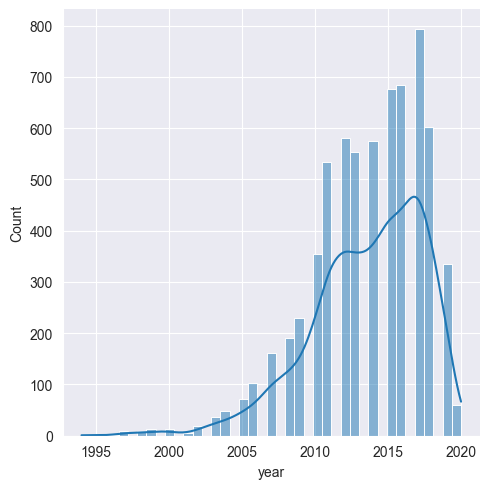

In [20]:
sns.displot(data=dff, x='year', kde=True)

<Axes: xlabel='selling_price'>

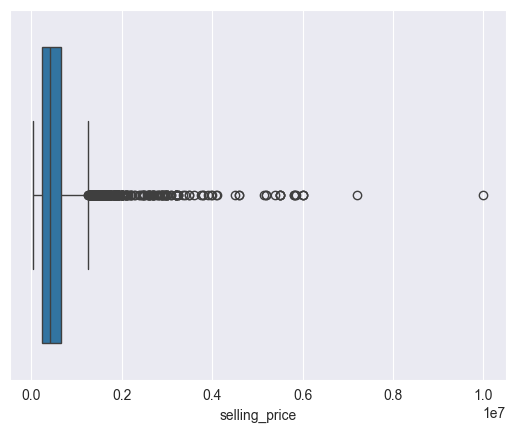

In [102]:
sns.boxplot(data=df, x='selling_price')

In [126]:
## Customs logistic regression 
class MyLogisticRegression:
    
    def __init__(self, cv:int=3, lr:float=0.1, 
                 max_iter:int=5000, weight_init:str='uniform', 
                 method:str='mini_batch', batch_size:int=64, l2:float=None,):
        self.lr = lr
        self.cv = cv
        self.max_iter = max_iter
        self.weight_init = weight_init
        self.method = method
        self.batch_size = batch_size
        self.l2 = 0 if l2 is None else l2
        
        valid_weight_init = ['uniform', 'normal', 'xavier','ones']
        
        if weight_init not in valid_weight_init:
            raise ValueError(f'weight_init must be one of {valid_weight_init}')
        
        valid_method = ['mini_batch', 'batch', 'stochastic']
        
        if method not in valid_method:
            raise ValueError(f'method must be one of {valid_method}')
        
    def fit(self, X, y):
        self.split = KFold(n_splits=self.cv)
        y_class = len(np.unique(y))

        if hasattr(X, "toarray"):
            X = X.toarray()  # Convert sparse matrix to dense

        # Ensure y is a NumPy array
        if not isinstance(y, np.ndarray):
            y = y.to_numpy() if hasattr(y, "to_numpy") else np.array(y)
        
        # One-Hot Encode y
        self.oh = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        y_encoded = self.oh.fit_transform(y.reshape(-1, 1))

        self.losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []

        for fold, (train_index, test_index) in enumerate(self.split.split(X)):
            X_train, X_val = X[train_index], X[test_index]
            y_train, y_val = y_encoded[train_index], y_encoded[test_index]

            X_train = self._add_intercept(X_train)
            X_val = self._add_intercept(X_val)

            self.W = self.weight_initializer(X_train, y_class)
            self.velocity = np.zeros_like(self.W)

            fold_train_losses = []
            fold_train_accuracies = []

            if self.method == 'mini_batch':
                for i in range(self.max_iter):
                    ix = np.random.randint(0, X_train.shape[0])
                    X_train_batch = X_train[ix:ix + self.batch_size]
                    y_train_batch = y_train[ix:ix + self.batch_size]
                    loss = self.train(X_train_batch, y_train_batch)
                    fold_train_losses.append(loss)

                    _, train_pred = self.predict(X_train_batch)
                    train_accuracy = np.mean(np.argmax(y_train_batch, axis=1) == train_pred)
                    fold_train_accuracies.append(train_accuracy)

                    if i % 500 == 0:
                        print(f"Iteration {i} - Loss: {loss:.4f}, Accuracy: {train_accuracy:.4f}")

            elif self.method == 'batch':
                for i in range(self.max_iter):
                    loss = self.train(X_train, y_train)
                    fold_train_losses.append(loss)

                    _, train_pred = self.predict(X_train)
                    train_accuracy = np.mean(np.argmax(y_train, axis=1) == train_pred)
                    fold_train_accuracies.append(train_accuracy)

                    if i % 500 == 0:
                        print(f"Iteration {i} - Loss: {loss:.4f}, Accuracy: {train_accuracy:.4f}")

            elif self.method == 'stochastic':
                for i in range(self.max_iter):
                    idx = np.random.randint(X_train.shape[0])  # Select a random index
                    X_sto = X_train[idx, :].reshape(1, -1)  # Get the single sample
                    y_sto = y_train[idx].reshape(1, -1)  # Get the corresponding label
                    
                    loss = self.train(X_sto, y_sto)  # Train the model on this single example
                    
                    if not np.isnan(loss):  # Ensure the loss is valid
                        fold_train_losses.append(loss)
                    
                    _, train_pred = self.predict(X_sto)  # Get predicted class
                    train_accuracy = np.mean(np.argmax(y_sto, axis=1) == train_pred)
                    fold_train_accuracies.append(train_accuracy)
        
                    if i % 500 == 0:
                        print(f"Iteration {i} - Loss: {loss:.4f}, Accuracy: {train_accuracy:.4f}")
                    
            # Store the average training loss & accuracy for this fold
            avg_train_loss = np.mean(fold_train_losses)
            avg_train_accuracy = np.mean(fold_train_accuracies)
            self.losses.append(avg_train_loss)
            self.train_accuracies.append(avg_train_accuracy)

            val_pred = self.predict(X_val)[1]  # Get predicted class labels
            y_val_labels = self.oh.inverse_transform(y_val)

            # Compute validation loss
            val_loss = self.cross_entropy(self.softmax_(X_val @ self.W), y_val)
            self.valid_losses.append(val_loss)

            # Compute validation accuracy
            val_accuracy = np.mean(y_val_labels.flatten() == val_pred)
            self.valid_accuracies.append(val_accuracy)

            print(f"Fold: {fold}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
                
    def train(self, X, y):
        y_hat, _  = self.predict(X)

        error = y_hat - y
        m = max(X.shape[0], 1)  # Ensure division is valid

        loss = self.cross_entropy(y_hat, y) if m > 1 else float(np.mean(y_hat))
        
        grad = X.T @ error  +  2 * self.l2 * self.W 
        self.velocity = 0.8 * self.velocity - self.lr * grad
        self.W += self.velocity
        #self.W -= self.lr * grad
        
        return loss if not np.isnan(loss) else 0.0 
                
    def predict(self, X, is_test=False):
        if is_test:
            X = self._add_intercept(X)
    
        y_hat = X @ self.W
        y_hat = self.softmax_(y_hat)
        y_real = np.argmax(y_hat, axis=1)
        return y_hat, y_real
    
    def softmax_(self, X):
        X = np.array(X) 
        X_max = np.max(X, axis=1, keepdims=True)  # Find max per row
        exp_shifted = np.exp(X - X_max)  # Shift values for numerical stability
        return exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)  # Normalize
    
    def weight_initializer(self, X, num_classes):
        if self.weight_init == 'uniform':
            return np.random.uniform(low=-self.lr, high=self.lr, size=(X.shape[1], num_classes))
        elif self.weight_init == 'normal':
            return np.random.randn(X.shape[1], num_classes)
        elif self.weight_init == 'xavier':
            limit = np.sqrt(6 / (X.shape[1] + num_classes))
            return np.random.uniform(low=-limit, high=limit, size=(X.shape[1], num_classes))
        else:
            return np.ones((X.shape[1], num_classes))
        
    def cross_entropy(self, y, y_hat):
        if y_hat.size == 0 or y.size == 0:
            return 0.0  # Return zero loss to avoid NaN issues
    
        m = max(y.shape[0], 1)  # Prevent division by zero
        loss = - np.sum(y * np.log(y_hat + 1e-9))/m ## Prevent log(0)
        return  loss + self.l2*np.sum(self.W**2)
    
    def _add_intercept(self,X):
        return np.c_[np.ones(X.shape[0]), X]
    
    def classification_report(self, pred, y):
        # Ensure both pred and y are NumPy arrays
        pred = np.array(pred).flatten()
        y = np.array(y)
        
        if len(pred) == 0 or len(y) == 0:  # Prevent empty array issues
            return 0.0  # Return zero accuracy to avoid NaN
    
        # Extract unique labels from both predictions and ground truth
        labels = np.unique(np.concatenate((y, pred)))
        num_classes = len(labels)  # Update num_classes based on unique labels
    
        # Initialize confusion matrix
        cm = np.zeros((num_classes, num_classes), dtype=int)
        
        for true, pred_label in zip(y, pred):
            # Get index positions of true and predicted labels in `labels`
            true_idx = np.where(labels == true)[0]
            pred_idx = np.where(labels == pred_label)[0]
    
            if true_idx.size > 0 and pred_idx.size > 0:  # Check if valid indices exist
                cm[true_idx[0], pred_idx[0]] += 1
    
        # Compute metrics
        tp = np.diag(cm)
        fp = np.sum(cm, axis=0) - tp
        fn = np.sum(cm, axis=1) - tp
    
        precision = np.divide(tp, tp + fp, out=np.zeros_like(tp, dtype=float), where=(tp + fp) > 0)
        recall = np.divide(tp, tp + fn, out=np.zeros_like(tp, dtype=float), where=(tp + fn) > 0)
        f1_score = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(precision, dtype=float), where=(precision + recall) > 0)
        
        accuracy_score = np.sum(np.diag(cm)) / np.sum(cm) if np.sum(cm) > 0 else 0.0
        
        # Weighted metrics
        class_counts = np.array([(y == label).sum() for label in labels]) / len(y)
        weighted_precision = np.sum(class_counts * precision)
        weighted_recall = np.sum(class_counts * recall)
        weighted_f1 = np.sum(class_counts * f1_score)
    
        # Print report
        print("\nClassification Report:\n")
        print("{:<10} {:<10} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1-score"))
        print("-" * 40)
        for i, label in enumerate(labels):
            print(f"{label:<10} {precision[i]:<10.2f} {recall[i]:<10.2f} {f1_score[i]:<10.2f}")
    
        return round(accuracy_score, 2), round(weighted_precision, 2), round(weighted_recall, 2), round(weighted_f1, 2)
    
    
    def _coeff_and_biases(self, feature_names):
        if not hasattr(self, "W"):
            raise ValueError("Model is not trained yet. Fit the model before retrieving coefficients.")
        
        coef = self.W[1:,:]  # Exclude bias term
        bias = self.W[0, :]
        print(coef.shape, len(feature_names))
        # Create a DataFrame for easy interpretation
        coef_df = pd.DataFrame(coef, index=feature_names, columns=[f"Class_{i}" for i in range(coef.shape[1])] if coef.ndim > 1 else ["Coefficient"])
        
        print("\nTop Important Features:")
        print(coef_df.abs().sum(axis=1).sort_values(ascending=False).head(10))

        return coef_df, bias

<Axes: >

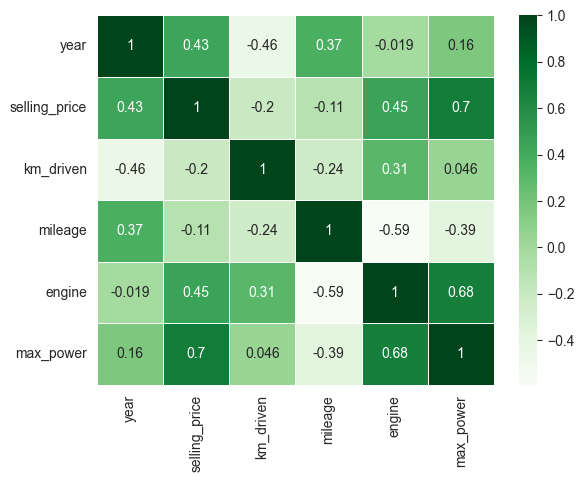

In [30]:
## remove engine, owners, seats
num_col = df.select_dtypes(include=['float','int64']).columns.tolist()
sns.heatmap(df[num_col].corr(), cmap='Greens', annot=True, linewidths=0.5)

In [81]:
df['selling_price'].describe()

count    6.663000e+03
mean     5.243708e+05
std      5.090416e+05
min      2.999900e+04
25%      2.500000e+05
50%      4.200000e+05
75%      6.500000e+05
max      1.000000e+07
Name: selling_price, dtype: float64

<Axes: xlabel='selling_price', ylabel='Count'>

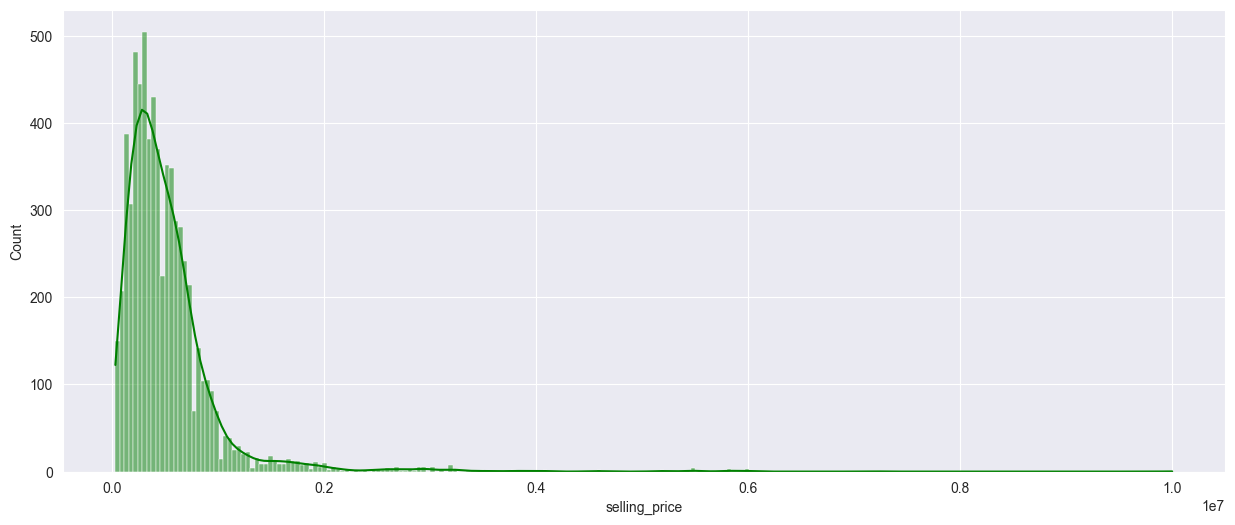

In [22]:
plt.figure(figsize=(15,6))
sns.histplot(data=df, x='selling_price', kde=True, color='green')

In [58]:
a = np.random.randint(low=1, high=100, size=(10,4))
print(a.shape, a.flatten().shape)

(10, 4) (40,)


In [131]:
model = MyLogisticRegression(weight_init='xavier', lr=0.0005, batch_size=64, max_iter=10000, method='batch', l2=0.01, cv=6)
model.fit(X_train_trf, ytrain)

Iteration 0 - Loss: 16.1528, Accuracy: 0.3506
Iteration 500 - Loss: 24.3523, Accuracy: 0.6938
Iteration 1000 - Loss: 32.4770, Accuracy: 0.7055
Iteration 1500 - Loss: 38.0704, Accuracy: 0.7084
Iteration 2000 - Loss: 42.0237, Accuracy: 0.7077
Iteration 2500 - Loss: 44.8405, Accuracy: 0.7068
Iteration 3000 - Loss: 46.8572, Accuracy: 0.7059
Iteration 3500 - Loss: 48.3098, Accuracy: 0.7059
Iteration 4000 - Loss: 49.3629, Accuracy: 0.7057
Iteration 4500 - Loss: 50.1312, Accuracy: 0.7059
Iteration 5000 - Loss: 50.6949, Accuracy: 0.7059
Iteration 5500 - Loss: 51.1106, Accuracy: 0.7059
Iteration 6000 - Loss: 51.4186, Accuracy: 0.7059
Iteration 6500 - Loss: 51.6476, Accuracy: 0.7061
Iteration 7000 - Loss: 51.8186, Accuracy: 0.7059
Iteration 7500 - Loss: 51.9467, Accuracy: 0.7055
Iteration 8000 - Loss: 52.0428, Accuracy: 0.7055
Iteration 8500 - Loss: 52.1152, Accuracy: 0.7055
Iteration 9000 - Loss: 52.1697, Accuracy: 0.7055
Iteration 9500 - Loss: 52.2110, Accuracy: 0.7055


KeyboardInterrupt: 

In [129]:
_ , pred = model.predict(X_test_trf, is_test=True)
print(model.classification_report(pred, ytest))
print(len(pred))


Classification Report:

Class      Precision  Recall     F1-score  
----------------------------------------
0          0.82       0.80       0.81      
1          0.65       0.71       0.67      
2          0.55       0.58       0.57      
3          0.83       0.64       0.72      
(np.float64(0.69), np.float64(0.7), np.float64(0.69), np.float64(0.69))
1333


In [23]:
w, _ = model._coeff_and_biases(feature_names) ##feature importance 
print(w)

(10, 4) 10

Top Important Features:
year                            70.910444
max_power                       62.449191
brand_encoded                   41.988500
transmission_Manual             20.355574
transmission_Automatic          19.649239
engine                          16.461500
seller_type_Dealer              14.305969
seller_type_Trustmark_Dealer    13.744468
seller_type_Individual          12.303999
km_driven                        2.546615
dtype: float64
                                Class_0   Class_1   Class_2    Class_3
seller_type_Individual         4.195689  1.595748 -1.612279  -4.900284
seller_type_Dealer             5.365360  1.982305 -1.525085  -5.433219
seller_type_Trustmark_Dealer   4.980829  1.376569 -1.562600  -5.824471
transmission_Automatic         7.014722  2.836298 -2.057484  -7.740735
transmission_Manual            7.256954  2.853230 -2.290312  -7.955079
year                         -26.786767 -8.279280  9.485558  26.358839
km_driven                     -0

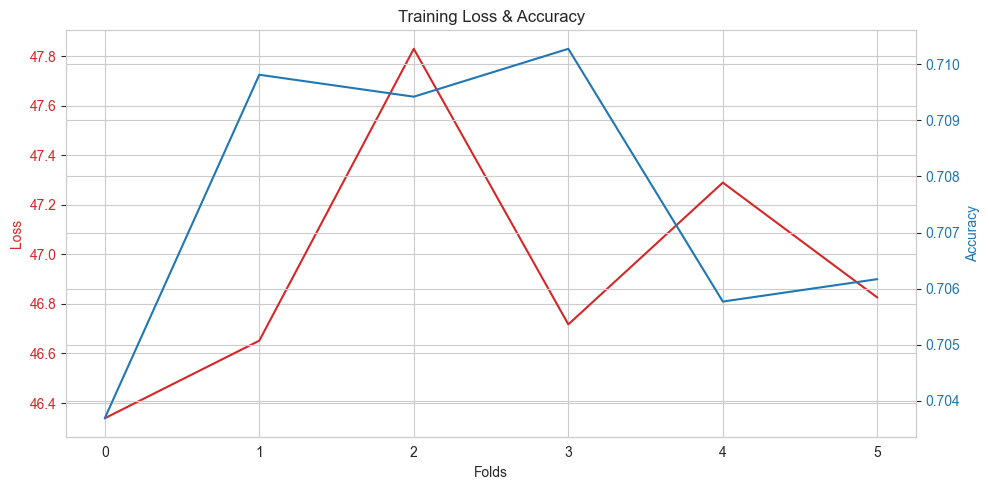

In [37]:
def plot_loss_accuracy(losses, accuracies, title="Training Progress"):
    """
    Plots training loss and accuracy over iterations.
    Returns:
    - None (Displays the plot)
    """
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel("Folds")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(losses, color="tab:red", label="Loss")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2 = ax1.twinx()  # Create a secondary y-axis
    ax2.set_ylabel("Accuracy", color="tab:blue")
    ax2.plot(accuracies, color="tab:blue", label="Accuracy")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    plt.title(title)
    fig.tight_layout()  # Adjust layout to prevent overlap

    plt.show()


plot_loss_accuracy(model.losses, model.train_accuracies, title="Training Loss & Accuracy")

In [43]:
joblib.dump(model, "model.pkl")
print("Preprocessor saved successfully!")

Preprocessor saved successfully!


In [141]:
#Load Environment Variables (for Authentication)
load_dotenv()
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))

os.environ["MLFLOW_TRACKING_USERNAME"] = os.getenv("MLFLOW_TRACKING_USERNAME")
os.environ["MLFLOW_TRACKING_PASSWORD"] = os.getenv("MLFLOW_TRACKING_PASSWORD")

# Define Experiment Name
STUDENT_ID = "st124783"
experiment_name = f"{STUDENT_ID}-a3"
mlflow.set_experiment(experiment_name)

# Define hyperparameters
methods = ["batch", "mini_batch", "stochastic"]
weights = ["xavier", "normal", "uniform"]
penalty = [None, 0.01]
lr = [0.01, 0.001, 0.0001]
batch_sizes = [64, 128]

num_features = X_train_trf.shape[1]  

# Generate input example **with bias term** (extra feature)
input_example = pd.DataFrame(
    np.hstack([np.ones((1, 1)), np.random.rand(1, num_features)]),  
    columns=["bias"] + [f"feature_{i}" for i in range(num_features)]
)

# Track Best Model
best_model_acc, best_acc, best_params_acc = None, float('-inf'), None
best_run_id = None

class MyLogisticRegressionWrapper(mlflow.pyfunc.PythonModel):
    """ Wrapper for Custom Logistic Regression Model """
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict(model_input)

def run_experiment(method, weight, lr, penalty, batch_size):
    """Runs ML experiments, logs results in MLflow, and tracks the best models."""
    global best_model_acc, best_acc, best_params_acc, best_run_id

    params = {
        "method": method, "lr": lr, "weight_init": weight, "l2": penalty, "batch_size": batch_size
    }

    print(f"Running MyLogisticRegression | {method} | {weight} | LR: {lr} | l2: {penalty} | Batch Size: {batch_size}")

    # nitialize Model
    model = MyLogisticRegression(lr=lr, max_iter=7000, weight_init=weight, method=method, batch_size=batch_size, l2=penalty)

    with mlflow.start_run(run_name=f"method-{method}-lr-{lr}-weight-{weight}-batch-{batch_size}", nested=True):
        # Train Model
        model.fit(X_train_trf, ytrain)

        # Predictions
        _, y_pred = model.predict(X_test_trf, is_test=True)

        # Compute Metrics
        acc, precision, recall, f1_score = model.classification_report(y_pred, ytest)

        # Log Hyperparameters & Metrics
        mlflow.log_params(params)
        mlflow.log_metrics({"accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1_score})

        # Save Model Signature
        signature = mlflow.models.infer_signature(input_example, model.predict(X_train_trf, is_test=True)[1])

        # Wrap Model for MLflow Logging
        logr_model_wrapper = MyLogisticRegressionWrapper(model)

        # Log Model Under Your Student ID Only
        mlflow.pyfunc.log_model(
            artifact_path="logr_model",
            python_model=logr_model_wrapper,
            signature=signature,
            input_example=input_example
             )

        print(f" Model: MyLogisticRegression | Method: {method} | Accuracy: {acc:.4f} | F1-Score: {f1_score:.4f}")

        # Track Best Model (Based on Accuracy)
        if acc > best_acc:
            best_acc = acc
            best_model_acc = model
            best_params_acc = params
            best_run_id = mlflow.active_run().info.run_id  # Save Best Run ID

# Run Experiments
combinations_ = product(methods, weights, lr, batch_sizes)

for method, weight, lr, batch_size in combinations_:
    run_experiment(method, weight, lr, None, batch_size)

# Final Results
print(f"Best Model by Accuracy: {best_model_acc} with Accuracy: {best_acc:.4f}")
mlflow.end_run()

if best_run_id:
    model_uri = f"runs:/{best_run_id}/logr_model"
    model_name = f"{STUDENT_ID}-a3-model"

    # Register Model with MLflow (Student ID Only)
    client = MlflowClient()
    model_version = mlflow.register_model(model_uri, model_name)
    print(f"\nRegistered Model: {model_name} (Version: {model_version})")

    # Transition Model to "Staging"
    client.transition_model_version_stage(
        name=model_name, 
        version=model_version.version,  
        stage="Staging"
    )
    print(f"Model {model_name} version {model_version.version} is now in 'Staging'!")


/Users/binit/PycharmProjects/ML_AIT_A3/pythonProject/.venv/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:134: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


Running MyLogisticRegression | batch | xavier | LR: 0.01 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.4873, Accuracy: 0.2643
Iteration 500 - Loss: 9.2120, Accuracy: 0.5941
Iteration 1000 - Loss: 8.7601, Accuracy: 0.5469
Iteration 1500 - Loss: 6.4154, Accuracy: 0.5094
Iteration 2000 - Loss: 8.5743, Accuracy: 0.5947
Iteration 2500 - Loss: 7.5074, Accuracy: 0.4999
Iteration 3000 - Loss: 8.9803, Accuracy: 0.6730
Iteration 3500 - Loss: 8.9621, Accuracy: 0.6015
Iteration 4000 - Loss: 9.1463, Accuracy: 0.6397
Iteration 4500 - Loss: 10.3946, Accuracy: 0.6395
Iteration 5000 - Loss: 9.9253, Accuracy: 0.5986
Iteration 5500 - Loss: 8.6033, Accuracy: 0.5792
Iteration 6000 - Loss: 6.3436, Accuracy: 0.5348
Iteration 6500 - Loss: 7.8295, Accuracy: 0.5046
Fold: 0, Train Loss: 8.5718, Train Accuracy: 0.5869, Val Loss: 6.1706, Val Accuracy: 0.7085
Iteration 0 - Loss: 15.1886, Accuracy: 0.3327
Iteration 500 - Loss: 10.0796, Accuracy: 0.6265
Iteration 1000 - Loss: 11.0450, Accuracy: 0.5683
Iteration 

2025/03/23 02:49:46 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.5800 | F1-Score: 0.5600
🏃 View run method-batch-lr-0.01-weight-xavier-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/438e7614a100439d80567794302597e5
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | xavier | LR: 0.01 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.7811, Accuracy: 0.3487
Iteration 500 - Loss: 8.4171, Accuracy: 0.5246
Iteration 1000 - Loss: 9.2059, Accuracy: 0.5367
Iteration 1500 - Loss: 7.4447, Accuracy: 0.5933
Iteration 2000 - Loss: 9.5340, Accuracy: 0.5607
Iteration 2500 - Loss: 6.5176, Accuracy: 0.6777
Iteration 3000 - Loss: 8.5005, Accuracy: 0.5795
Iteration 3500 - Loss: 8.2143, Accuracy: 0.6015
Iteration 4000 - Loss: 8.9368, Accuracy: 0.5725
Iteration 4500 - Loss: 6.2901, Accuracy: 0.6817
Iteration 5000 - Loss: 9.6213, Accuracy: 0.6068
Iteration 5500 - Loss: 9.7258, Accuracy: 0.6023

2025/03/23 02:50:00 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.5800 | F1-Score: 0.5400
🏃 View run method-batch-lr-0.01-weight-xavier-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/68b2cfcdf52249d2a9a92048e6c263e1
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | xavier | LR: 0.001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.2991, Accuracy: 0.4208
Iteration 500 - Loss: 8.9076, Accuracy: 0.7022
Iteration 1000 - Loss: 8.5879, Accuracy: 0.7109
Iteration 1500 - Loss: 8.4481, Accuracy: 0.7087
Iteration 2000 - Loss: 8.3746, Accuracy: 0.7090
Iteration 2500 - Loss: 8.3327, Accuracy: 0.7081
Iteration 3000 - Loss: 8.3075, Accuracy: 0.7079
Iteration 3500 - Loss: 8.2919, Accuracy: 0.7059
Iteration 4000 - Loss: 8.2821, Accuracy: 0.7056
Iteration 4500 - Loss: 8.2757, Accuracy: 0.7039
Iteration 5000 - Loss: 8.2715, Accuracy: 0.7033
Iteration 5500 - Loss: 8.2687, Accuracy: 0.703

2025/03/23 02:50:14 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6800 | F1-Score: 0.6800
🏃 View run method-batch-lr-0.001-weight-xavier-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/d70dff94cbce457c91aaca6916741a37
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | xavier | LR: 0.001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 16.1704, Accuracy: 0.3487
Iteration 500 - Loss: 8.9238, Accuracy: 0.7017
Iteration 1000 - Loss: 8.5931, Accuracy: 0.7104
Iteration 1500 - Loss: 8.4506, Accuracy: 0.7087
Iteration 2000 - Loss: 8.3760, Accuracy: 0.7090
Iteration 2500 - Loss: 8.3335, Accuracy: 0.7081
Iteration 3000 - Loss: 8.3080, Accuracy: 0.7081
Iteration 3500 - Loss: 8.2922, Accuracy: 0.7059
Iteration 4000 - Loss: 8.2822, Accuracy: 0.7056
Iteration 4500 - Loss: 8.2758, Accuracy: 0.7039
Iteration 5000 - Loss: 8.2716, Accuracy: 0.7033
Iteration 5500 - Loss: 8.2688, Accuracy: 0.70

2025/03/23 02:50:28 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6800 | F1-Score: 0.6800
🏃 View run method-batch-lr-0.001-weight-xavier-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/1318717e2df94e6798f617014936a3dc
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | xavier | LR: 0.0001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 16.1949, Accuracy: 0.1317
Iteration 500 - Loss: 10.9099, Accuracy: 0.6544
Iteration 1000 - Loss: 10.1968, Accuracy: 0.6772
Iteration 1500 - Loss: 9.8214, Accuracy: 0.6800
Iteration 2000 - Loss: 9.5778, Accuracy: 0.6893
Iteration 2500 - Loss: 9.4031, Accuracy: 0.6938
Iteration 3000 - Loss: 9.2698, Accuracy: 0.6969
Iteration 3500 - Loss: 9.1638, Accuracy: 0.6994
Iteration 4000 - Loss: 9.0770, Accuracy: 0.7005
Iteration 4500 - Loss: 9.0042, Accuracy: 0.7014
Iteration 5000 - Loss: 8.9421, Accuracy: 0.7014
Iteration 5500 - Loss: 8.8883, Accuracy: 0

2025/03/23 02:50:42 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6900 | F1-Score: 0.6900
🏃 View run method-batch-lr-0.0001-weight-xavier-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/450a3c756a9444799e8f955ef90a8eb3
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | xavier | LR: 0.0001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.2459, Accuracy: 0.3510
Iteration 500 - Loss: 10.9149, Accuracy: 0.6541
Iteration 1000 - Loss: 10.1991, Accuracy: 0.6760
Iteration 1500 - Loss: 9.8226, Accuracy: 0.6811
Iteration 2000 - Loss: 9.5784, Accuracy: 0.6896
Iteration 2500 - Loss: 9.4033, Accuracy: 0.6943
Iteration 3000 - Loss: 9.2697, Accuracy: 0.6972
Iteration 3500 - Loss: 9.1636, Accuracy: 0.6991
Iteration 4000 - Loss: 9.0766, Accuracy: 0.7005
Iteration 4500 - Loss: 9.0037, Accuracy: 0.7014
Iteration 5000 - Loss: 8.9415, Accuracy: 0.7014
Iteration 5500 - Loss: 8.8875, Accuracy: 

2025/03/23 02:50:56 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6900 | F1-Score: 0.6900
🏃 View run method-batch-lr-0.0001-weight-xavier-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/ce85013802fa474db661a77edde74a45
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | normal | LR: 0.01 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.8425, Accuracy: 0.3487
Iteration 500 - Loss: 10.4937, Accuracy: 0.5108
Iteration 1000 - Loss: 8.4206, Accuracy: 0.5153
Iteration 1500 - Loss: 7.9573, Accuracy: 0.5255
Iteration 2000 - Loss: 10.7662, Accuracy: 0.6172
Iteration 2500 - Loss: 7.6942, Accuracy: 0.6355
Iteration 3000 - Loss: 7.5732, Accuracy: 0.6670
Iteration 3500 - Loss: 6.5305, Accuracy: 0.6138
Iteration 4000 - Loss: 10.2937, Accuracy: 0.5891
Iteration 4500 - Loss: 8.2571, Accuracy: 0.6237
Iteration 5000 - Loss: 6.2237, Accuracy: 0.6226
Iteration 5500 - Loss: 6.7783, Accuracy: 0

2025/03/23 02:51:10 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.5400 | F1-Score: 0.4500
🏃 View run method-batch-lr-0.01-weight-normal-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/3cbc29ff911047d1bbcc64752500be32
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | normal | LR: 0.01 | l2: None | Batch Size: 128
Iteration 0 - Loss: 14.2933, Accuracy: 0.2809
Iteration 500 - Loss: 6.4327, Accuracy: 0.5941
Iteration 1000 - Loss: 8.0463, Accuracy: 0.5936
Iteration 1500 - Loss: 8.6016, Accuracy: 0.5809
Iteration 2000 - Loss: 6.4611, Accuracy: 0.6009
Iteration 2500 - Loss: 7.8831, Accuracy: 0.5094
Iteration 3000 - Loss: 7.4595, Accuracy: 0.6530
Iteration 3500 - Loss: 6.1831, Accuracy: 0.5775
Iteration 4000 - Loss: 8.4894, Accuracy: 0.6175
Iteration 4500 - Loss: 7.9612, Accuracy: 0.5049
Iteration 5000 - Loss: 9.1109, Accuracy: 0.6327
Iteration 5500 - Loss: 8.2117, Accuracy: 0.4695

2025/03/23 02:51:24 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.5800 | F1-Score: 0.5600
🏃 View run method-batch-lr-0.01-weight-normal-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/f4e07305a82f4705a7606dade29f837f
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | normal | LR: 0.001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.9797, Accuracy: 0.3290
Iteration 500 - Loss: 8.9094, Accuracy: 0.7022
Iteration 1000 - Loss: 8.5867, Accuracy: 0.7107
Iteration 1500 - Loss: 8.4473, Accuracy: 0.7087
Iteration 2000 - Loss: 8.3742, Accuracy: 0.7090
Iteration 2500 - Loss: 8.3324, Accuracy: 0.7081
Iteration 3000 - Loss: 8.3074, Accuracy: 0.7079
Iteration 3500 - Loss: 8.2919, Accuracy: 0.7059
Iteration 4000 - Loss: 8.2820, Accuracy: 0.7056
Iteration 4500 - Loss: 8.2756, Accuracy: 0.7039
Iteration 5000 - Loss: 8.2715, Accuracy: 0.7033
Iteration 5500 - Loss: 8.2687, Accuracy: 0.703

2025/03/23 02:51:38 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6800 | F1-Score: 0.6800
🏃 View run method-batch-lr-0.001-weight-normal-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/6c8e9bbadd1a49f19de651661164c237
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | normal | LR: 0.001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.6422, Accuracy: 0.3394
Iteration 500 - Loss: 8.9190, Accuracy: 0.7017
Iteration 1000 - Loss: 8.5945, Accuracy: 0.7107
Iteration 1500 - Loss: 8.4522, Accuracy: 0.7095
Iteration 2000 - Loss: 8.3771, Accuracy: 0.7090
Iteration 2500 - Loss: 8.3342, Accuracy: 0.7081
Iteration 3000 - Loss: 8.3085, Accuracy: 0.7081
Iteration 3500 - Loss: 8.2926, Accuracy: 0.7059
Iteration 4000 - Loss: 8.2825, Accuracy: 0.7056
Iteration 4500 - Loss: 8.2760, Accuracy: 0.7039
Iteration 5000 - Loss: 8.2717, Accuracy: 0.7033
Iteration 5500 - Loss: 8.2689, Accuracy: 0.70

2025/03/23 02:51:52 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6800 | F1-Score: 0.6800
🏃 View run method-batch-lr-0.001-weight-normal-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/a67c652a78b64927984bb966bcdb41b9
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | normal | LR: 0.0001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.4174, Accuracy: 0.2840
Iteration 500 - Loss: 10.8716, Accuracy: 0.6547
Iteration 1000 - Loss: 10.1713, Accuracy: 0.6777
Iteration 1500 - Loss: 9.8024, Accuracy: 0.6811
Iteration 2000 - Loss: 9.5627, Accuracy: 0.6898
Iteration 2500 - Loss: 9.3904, Accuracy: 0.6941
Iteration 3000 - Loss: 9.2590, Accuracy: 0.6977
Iteration 3500 - Loss: 9.1544, Accuracy: 0.6997
Iteration 4000 - Loss: 9.0687, Accuracy: 0.7005
Iteration 4500 - Loss: 8.9968, Accuracy: 0.7008
Iteration 5000 - Loss: 8.9354, Accuracy: 0.7019
Iteration 5500 - Loss: 8.8822, Accuracy: 0

2025/03/23 02:52:06 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6900 | F1-Score: 0.6900
🏃 View run method-batch-lr-0.0001-weight-normal-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/5a4a63094de74e6db2ca2085f705c1ee
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | normal | LR: 0.0001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.6713, Accuracy: 0.3118
Iteration 500 - Loss: 10.9319, Accuracy: 0.6507
Iteration 1000 - Loss: 10.2074, Accuracy: 0.6749
Iteration 1500 - Loss: 9.8283, Accuracy: 0.6811
Iteration 2000 - Loss: 9.5831, Accuracy: 0.6887
Iteration 2500 - Loss: 9.4075, Accuracy: 0.6943
Iteration 3000 - Loss: 9.2736, Accuracy: 0.6969
Iteration 3500 - Loss: 9.1672, Accuracy: 0.6980
Iteration 4000 - Loss: 9.0800, Accuracy: 0.7014
Iteration 4500 - Loss: 9.0069, Accuracy: 0.7017
Iteration 5000 - Loss: 8.9444, Accuracy: 0.7017
Iteration 5500 - Loss: 8.8903, Accuracy: 

2025/03/23 02:52:20 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6900 | F1-Score: 0.6900
🏃 View run method-batch-lr-0.0001-weight-normal-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/b3c5374350464ccd96858ef03d39f856
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | uniform | LR: 0.01 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.5527, Accuracy: 0.3487
Iteration 500 - Loss: 8.8820, Accuracy: 0.4348
Iteration 1000 - Loss: 9.8219, Accuracy: 0.6941
Iteration 1500 - Loss: 9.3027, Accuracy: 0.5789
Iteration 2000 - Loss: 7.1287, Accuracy: 0.6786
Iteration 2500 - Loss: 10.4281, Accuracy: 0.6243
Iteration 3000 - Loss: 8.5891, Accuracy: 0.4712
Iteration 3500 - Loss: 7.7157, Accuracy: 0.5449
Iteration 4000 - Loss: 8.1457, Accuracy: 0.6217
Iteration 4500 - Loss: 6.8553, Accuracy: 0.6358
Iteration 5000 - Loss: 7.0489, Accuracy: 0.5854
Iteration 5500 - Loss: 6.4830, Accuracy: 0.

2025/03/23 02:52:34 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.4900 | F1-Score: 0.4300
🏃 View run method-batch-lr-0.01-weight-uniform-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/9110a8519e204a658300b862b4bbe8ba
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | uniform | LR: 0.01 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.5372, Accuracy: 0.3487
Iteration 500 - Loss: 7.2547, Accuracy: 0.6375
Iteration 1000 - Loss: 10.7968, Accuracy: 0.5623
Iteration 1500 - Loss: 6.8624, Accuracy: 0.6699
Iteration 2000 - Loss: 10.3278, Accuracy: 0.7081
Iteration 2500 - Loss: 10.1217, Accuracy: 0.6589
Iteration 3000 - Loss: 8.1093, Accuracy: 0.4959
Iteration 3500 - Loss: 9.2223, Accuracy: 0.5694
Iteration 4000 - Loss: 8.3450, Accuracy: 0.6108
Iteration 4500 - Loss: 8.5174, Accuracy: 0.6637
Iteration 5000 - Loss: 7.8760, Accuracy: 0.5412
Iteration 5500 - Loss: 8.6803, Accuracy: 0

2025/03/23 02:52:48 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6200 | F1-Score: 0.5400
🏃 View run method-batch-lr-0.01-weight-uniform-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/b40da2d8a35b4564be42a6bce648778f
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | uniform | LR: 0.001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.5435, Accuracy: 0.3487
Iteration 500 - Loss: 8.9174, Accuracy: 0.7022
Iteration 1000 - Loss: 8.5913, Accuracy: 0.7107
Iteration 1500 - Loss: 8.4497, Accuracy: 0.7087
Iteration 2000 - Loss: 8.3755, Accuracy: 0.7090
Iteration 2500 - Loss: 8.3332, Accuracy: 0.7081
Iteration 3000 - Loss: 8.3078, Accuracy: 0.7079
Iteration 3500 - Loss: 8.2921, Accuracy: 0.7059
Iteration 4000 - Loss: 8.2822, Accuracy: 0.7056
Iteration 4500 - Loss: 8.2757, Accuracy: 0.7039
Iteration 5000 - Loss: 8.2715, Accuracy: 0.7033
Iteration 5500 - Loss: 8.2688, Accuracy: 0.7

2025/03/23 02:53:02 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6800 | F1-Score: 0.6800
🏃 View run method-batch-lr-0.001-weight-uniform-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/eeb9c95326a0431d9ae13d9912300a18
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | uniform | LR: 0.001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.5424, Accuracy: 0.3487
Iteration 500 - Loss: 8.9058, Accuracy: 0.7022
Iteration 1000 - Loss: 8.5879, Accuracy: 0.7107
Iteration 1500 - Loss: 8.4482, Accuracy: 0.7087
Iteration 2000 - Loss: 8.3747, Accuracy: 0.7090
Iteration 2500 - Loss: 8.3327, Accuracy: 0.7081
Iteration 3000 - Loss: 8.3075, Accuracy: 0.7079
Iteration 3500 - Loss: 8.2919, Accuracy: 0.7059
Iteration 4000 - Loss: 8.2821, Accuracy: 0.7056
Iteration 4500 - Loss: 8.2757, Accuracy: 0.7039
Iteration 5000 - Loss: 8.2715, Accuracy: 0.7033
Iteration 5500 - Loss: 8.2687, Accuracy: 0.

2025/03/23 02:53:16 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6800 | F1-Score: 0.6800
🏃 View run method-batch-lr-0.001-weight-uniform-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/01060515419b436c9b5348360931dfe9
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | uniform | LR: 0.0001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.5423, Accuracy: 0.3487
Iteration 500 - Loss: 10.9264, Accuracy: 0.6538
Iteration 1000 - Loss: 10.2079, Accuracy: 0.6744
Iteration 1500 - Loss: 9.8295, Accuracy: 0.6800
Iteration 2000 - Loss: 9.5840, Accuracy: 0.6884
Iteration 2500 - Loss: 9.4080, Accuracy: 0.6935
Iteration 3000 - Loss: 9.2738, Accuracy: 0.6972
Iteration 3500 - Loss: 9.1672, Accuracy: 0.6991
Iteration 4000 - Loss: 9.0798, Accuracy: 0.7000
Iteration 4500 - Loss: 9.0066, Accuracy: 0.7017
Iteration 5000 - Loss: 8.9441, Accuracy: 0.7014
Iteration 5500 - Loss: 8.8899, Accuracy:

2025/03/23 02:53:30 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6900 | F1-Score: 0.6900
🏃 View run method-batch-lr-0.0001-weight-uniform-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/1c9c1a8dd3a346f5a8fa8e4da9f9ed07
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | batch | uniform | LR: 0.0001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.5424, Accuracy: 0.3487
Iteration 500 - Loss: 10.9264, Accuracy: 0.6538
Iteration 1000 - Loss: 10.2079, Accuracy: 0.6744
Iteration 1500 - Loss: 9.8295, Accuracy: 0.6800
Iteration 2000 - Loss: 9.5840, Accuracy: 0.6884
Iteration 2500 - Loss: 9.4080, Accuracy: 0.6935
Iteration 3000 - Loss: 9.2738, Accuracy: 0.6972
Iteration 3500 - Loss: 9.1672, Accuracy: 0.6991
Iteration 4000 - Loss: 9.0798, Accuracy: 0.7000
Iteration 4500 - Loss: 9.0066, Accuracy: 0.7017
Iteration 5000 - Loss: 8.9441, Accuracy: 0.7014
Iteration 5500 - Loss: 8.8899, Accuracy

2025/03/23 02:53:43 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: batch | Accuracy: 0.6900 | F1-Score: 0.6900
🏃 View run method-batch-lr-0.0001-weight-uniform-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/7781473e1d97464e857404d16b5ca0a0
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | xavier | LR: 0.01 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.5201, Accuracy: 0.3594
Iteration 500 - Loss: 9.4622, Accuracy: 0.6719
Iteration 1000 - Loss: 10.3088, Accuracy: 0.5781
Iteration 1500 - Loss: 9.0035, Accuracy: 0.7188
Iteration 2000 - Loss: 10.0563, Accuracy: 0.6562
Iteration 2500 - Loss: 8.5474, Accuracy: 0.7500
Iteration 3000 - Loss: 9.5058, Accuracy: 0.7344
Iteration 3500 - Loss: 10.1980, Accuracy: 0.6719
Iteration 4000 - Loss: 7.2974, Accuracy: 0.7969
Iteration 4500 - Loss: 8.6840, Accuracy: 0.7031
Iteration 5000 - Loss: 8.2860, Accuracy: 0.7969
Iteration 5500 - Loss: 10.1092, Accu

2025/03/23 02:53:48 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6800 | F1-Score: 0.6800
🏃 View run method-mini_batch-lr-0.01-weight-xavier-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/0a5aaaa40ede4bcc8d02f7588e95ea34
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | xavier | LR: 0.01 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.7224, Accuracy: 0.4453
Iteration 500 - Loss: 9.7544, Accuracy: 0.6797
Iteration 1000 - Loss: 9.6253, Accuracy: 0.6562
Iteration 1500 - Loss: 8.7984, Accuracy: 0.6797
Iteration 2000 - Loss: 8.6481, Accuracy: 0.6797
Iteration 2500 - Loss: 8.4945, Accuracy: 0.6641
Iteration 3000 - Loss: 8.5005, Accuracy: 0.7344
Iteration 3500 - Loss: 7.7328, Accuracy: 0.7891
Iteration 4000 - Loss: 8.8271, Accuracy: 0.7109
Iteration 4500 - Loss: 8.3280, Accuracy: 0.7422
Iteration 5000 - Loss: 8.8925, Accuracy: 0.6406
Iteration 5500 - Loss: 8.2421, A

2025/03/23 02:53:52 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6500 | F1-Score: 0.6400
🏃 View run method-mini_batch-lr-0.01-weight-xavier-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/397b80d5a1114e09a897bca2e1998328
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | xavier | LR: 0.001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.6638, Accuracy: 0.1875
Iteration 500 - Loss: 12.4273, Accuracy: 0.6094
Iteration 1000 - Loss: 12.2438, Accuracy: 0.6719
Iteration 1500 - Loss: 11.6431, Accuracy: 0.6250
Iteration 2000 - Loss: 10.4939, Accuracy: 0.7500
Iteration 2500 - Loss: 10.8942, Accuracy: 0.6094
Iteration 3000 - Loss: 10.8438, Accuracy: 0.6875
Iteration 3500 - Loss: 11.0330, Accuracy: 0.5469
Iteration 4000 - Loss: 10.2855, Accuracy: 0.6562
Iteration 4500 - Loss: 10.5406, Accuracy: 0.7031
Iteration 5000 - Loss: 10.9439, Accuracy: 0.6406
Iteration 5500 - Loss

2025/03/23 02:53:57 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6300 | F1-Score: 0.6200
🏃 View run method-mini_batch-lr-0.001-weight-xavier-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/e9e9c05de2f0485eb2573af7faafdad3
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | xavier | LR: 0.001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.2177, Accuracy: 0.3281
Iteration 500 - Loss: 12.4245, Accuracy: 0.5859
Iteration 1000 - Loss: 11.1771, Accuracy: 0.6094
Iteration 1500 - Loss: 10.7857, Accuracy: 0.6328
Iteration 2000 - Loss: 10.1084, Accuracy: 0.6797
Iteration 2500 - Loss: 10.4698, Accuracy: 0.6724
Iteration 3000 - Loss: 10.3073, Accuracy: 0.6406
Iteration 3500 - Loss: 9.8751, Accuracy: 0.6641
Iteration 4000 - Loss: 9.2388, Accuracy: 0.7266
Iteration 4500 - Loss: 10.0016, Accuracy: 0.6797
Iteration 5000 - Loss: 9.5260, Accuracy: 0.6953
Iteration 5500 - Loss: 

2025/03/23 02:54:01 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6700 | F1-Score: 0.6700
🏃 View run method-mini_batch-lr-0.001-weight-xavier-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/4f3194fa160a47f2998beae1544294c1
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | xavier | LR: 0.0001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.2107, Accuracy: 0.4219
Iteration 500 - Loss: 14.8338, Accuracy: 0.3281
Iteration 1000 - Loss: 14.0988, Accuracy: 0.4375
Iteration 1500 - Loss: 13.8853, Accuracy: 0.5156
Iteration 2000 - Loss: 14.0172, Accuracy: 0.4531
Iteration 2500 - Loss: 13.7610, Accuracy: 0.4531
Iteration 3000 - Loss: 13.5563, Accuracy: 0.5469
Iteration 3500 - Loss: 12.9852, Accuracy: 0.5312
Iteration 4000 - Loss: 12.7650, Accuracy: 0.6250
Iteration 4500 - Loss: 13.4908, Accuracy: 0.4219
Iteration 5000 - Loss: 12.7500, Accuracy: 0.5938
Iteration 5500 - Lo

2025/03/23 02:54:06 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.5500 | F1-Score: 0.5200
🏃 View run method-mini_batch-lr-0.0001-weight-xavier-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/b8b851179e34429e9d3113ba64fd30ba
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | xavier | LR: 0.0001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.2990, Accuracy: 0.2344
Iteration 500 - Loss: 14.2021, Accuracy: 0.4375
Iteration 1000 - Loss: 13.4018, Accuracy: 0.5469
Iteration 1500 - Loss: 13.4778, Accuracy: 0.5391
Iteration 2000 - Loss: 13.4754, Accuracy: 0.5234
Iteration 2500 - Loss: 12.5159, Accuracy: 0.5781
Iteration 3000 - Loss: 13.0611, Accuracy: 0.5234
Iteration 3500 - Loss: 12.3393, Accuracy: 0.5859
Iteration 4000 - Loss: 12.7202, Accuracy: 0.5234
Iteration 4500 - Loss: 12.6231, Accuracy: 0.5391
Iteration 5000 - Loss: 12.5471, Accuracy: 0.5312
Iteration 5500 - L

2025/03/23 02:54:10 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6000 | F1-Score: 0.5800
🏃 View run method-mini_batch-lr-0.0001-weight-xavier-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/b8464ed09c1944169e675b3e3ff29544
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | normal | LR: 0.01 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.7057, Accuracy: 0.4062
Iteration 500 - Loss: 10.8156, Accuracy: 0.6250
Iteration 1000 - Loss: 10.1839, Accuracy: 0.6094
Iteration 1500 - Loss: 8.8353, Accuracy: 0.7500
Iteration 2000 - Loss: 9.4558, Accuracy: 0.6094
Iteration 2500 - Loss: 8.0375, Accuracy: 0.7812
Iteration 3000 - Loss: 9.9489, Accuracy: 0.7656
Iteration 3500 - Loss: 9.7607, Accuracy: 0.6719
Iteration 4000 - Loss: 8.9213, Accuracy: 0.6875
Iteration 4500 - Loss: 8.6269, Accuracy: 0.6719
Iteration 5000 - Loss: 9.3889, Accuracy: 0.6562
Iteration 5500 - Loss: 8.285

2025/03/23 02:54:15 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6600 | F1-Score: 0.6600
🏃 View run method-mini_batch-lr-0.01-weight-normal-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/b5aafebbc0d044a18c339004387d8c30
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | normal | LR: 0.01 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.3673, Accuracy: 0.3359
Iteration 500 - Loss: 10.3135, Accuracy: 0.5938
Iteration 1000 - Loss: 10.0583, Accuracy: 0.6641
Iteration 1500 - Loss: 8.3630, Accuracy: 0.7344
Iteration 2000 - Loss: 8.6462, Accuracy: 0.7109
Iteration 2500 - Loss: 7.5570, Accuracy: 0.7734
Iteration 3000 - Loss: 8.5336, Accuracy: 0.6641
Iteration 3500 - Loss: 8.7449, Accuracy: 0.6875
Iteration 4000 - Loss: 8.8290, Accuracy: 0.7109
Iteration 4500 - Loss: 8.7131, Accuracy: 0.6797
Iteration 5000 - Loss: 8.4692, Accuracy: 0.6953
Iteration 5500 - Loss: 9.0076,

2025/03/23 02:54:19 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6900 | F1-Score: 0.6900
🏃 View run method-mini_batch-lr-0.01-weight-normal-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/5e526ecc847f4501944bf9f9a3de3f73
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | normal | LR: 0.001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.4915, Accuracy: 0.2812
Iteration 500 - Loss: 13.1057, Accuracy: 0.4844
Iteration 1000 - Loss: 11.4118, Accuracy: 0.5938
Iteration 1500 - Loss: 11.7374, Accuracy: 0.6094
Iteration 2000 - Loss: 10.5829, Accuracy: 0.6719
Iteration 2500 - Loss: 12.2993, Accuracy: 0.4531
Iteration 3000 - Loss: 10.8407, Accuracy: 0.6719
Iteration 3500 - Loss: 10.3772, Accuracy: 0.6094
Iteration 4000 - Loss: 11.8920, Accuracy: 0.5781
Iteration 4500 - Loss: 9.4055, Accuracy: 0.7812
Iteration 5000 - Loss: 10.3018, Accuracy: 0.6875
Iteration 5500 - Loss:

2025/03/23 02:54:24 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6400 | F1-Score: 0.6300
🏃 View run method-mini_batch-lr-0.001-weight-normal-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/5c94f32aab304d268b308aa0e3c4def8
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | normal | LR: 0.001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 14.5245, Accuracy: 0.3047
Iteration 500 - Loss: 12.6881, Accuracy: 0.4922
Iteration 1000 - Loss: 11.5335, Accuracy: 0.5938
Iteration 1500 - Loss: 10.4692, Accuracy: 0.6719
Iteration 2000 - Loss: 11.0614, Accuracy: 0.6250
Iteration 2500 - Loss: 9.7652, Accuracy: 0.7031
Iteration 3000 - Loss: 9.8086, Accuracy: 0.7266
Iteration 3500 - Loss: 9.8286, Accuracy: 0.6875
Iteration 4000 - Loss: 10.3343, Accuracy: 0.6016
Iteration 4500 - Loss: 9.3840, Accuracy: 0.7266
Iteration 5000 - Loss: 10.2128, Accuracy: 0.6172
Iteration 5500 - Loss: 8

2025/03/23 02:54:29 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6500 | F1-Score: 0.6400
🏃 View run method-mini_batch-lr-0.001-weight-normal-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/549d9ffe0e8a4145b37e50b722a78703
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | normal | LR: 0.0001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.8111, Accuracy: 0.2031
Iteration 500 - Loss: 15.4662, Accuracy: 0.3333
Iteration 1000 - Loss: 13.9602, Accuracy: 0.5000
Iteration 1500 - Loss: 13.6099, Accuracy: 0.5938
Iteration 2000 - Loss: 14.2784, Accuracy: 0.4531
Iteration 2500 - Loss: 13.3926, Accuracy: 0.5781
Iteration 3000 - Loss: 13.0453, Accuracy: 0.6406
Iteration 3500 - Loss: 13.4270, Accuracy: 0.5625
Iteration 4000 - Loss: 12.9503, Accuracy: 0.6250
Iteration 4500 - Loss: 12.9847, Accuracy: 0.6250
Iteration 5000 - Loss: 12.8957, Accuracy: 0.5312
Iteration 5500 - Lo

2025/03/23 02:54:33 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.5500 | F1-Score: 0.5200
🏃 View run method-mini_batch-lr-0.0001-weight-normal-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/d4215a7191de433a97833d33cfb10a0a
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | normal | LR: 0.0001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 17.4033, Accuracy: 0.1562
Iteration 500 - Loss: 13.7396, Accuracy: 0.5625
Iteration 1000 - Loss: 13.7738, Accuracy: 0.5391
Iteration 1500 - Loss: 13.5303, Accuracy: 0.4766
Iteration 2000 - Loss: 13.3840, Accuracy: 0.5000
Iteration 2500 - Loss: 13.3206, Accuracy: 0.4922
Iteration 3000 - Loss: 12.8990, Accuracy: 0.5156
Iteration 3500 - Loss: 12.2914, Accuracy: 0.6250
Iteration 4000 - Loss: 12.7908, Accuracy: 0.4922
Iteration 4500 - Loss: 12.2697, Accuracy: 0.6094
Iteration 5000 - Loss: 11.8721, Accuracy: 0.6484
Iteration 5500 - L

2025/03/23 02:54:38 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6000 | F1-Score: 0.5900
🏃 View run method-mini_batch-lr-0.0001-weight-normal-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/f18910ad5fe04ca2b13bed96a77ff369
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | uniform | LR: 0.01 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.5395, Accuracy: 0.3594
Iteration 500 - Loss: 9.8342, Accuracy: 0.6250
Iteration 1000 - Loss: 9.6702, Accuracy: 0.7188
Iteration 1500 - Loss: 9.4278, Accuracy: 0.6875
Iteration 2000 - Loss: 9.1350, Accuracy: 0.6875
Iteration 2500 - Loss: 8.3577, Accuracy: 0.7656
Iteration 3000 - Loss: 9.7256, Accuracy: 0.5938
Iteration 3500 - Loss: 8.7864, Accuracy: 0.6875
Iteration 4000 - Loss: 9.0566, Accuracy: 0.6719
Iteration 4500 - Loss: 8.5357, Accuracy: 0.7031
Iteration 5000 - Loss: 9.6277, Accuracy: 0.6094
Iteration 5500 - Loss: 8.4958

2025/03/23 02:54:42 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6700 | F1-Score: 0.6600
🏃 View run method-mini_batch-lr-0.01-weight-uniform-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/060fac8fb76f4aa39df6be4258fca47a
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | uniform | LR: 0.01 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.5505, Accuracy: 0.3359
Iteration 500 - Loss: 9.2999, Accuracy: 0.6641
Iteration 1000 - Loss: 8.8418, Accuracy: 0.6484
Iteration 1500 - Loss: 8.5933, Accuracy: 0.7500
Iteration 2000 - Loss: 8.2623, Accuracy: 0.7266
Iteration 2500 - Loss: 8.6661, Accuracy: 0.7188
Iteration 3000 - Loss: 7.9738, Accuracy: 0.7422
Iteration 3500 - Loss: 9.2944, Accuracy: 0.6484
Iteration 4000 - Loss: 8.0007, Accuracy: 0.6719
Iteration 4500 - Loss: 7.4504, Accuracy: 0.7891
Iteration 5000 - Loss: 8.8391, Accuracy: 0.6797
Iteration 5500 - Loss: 8.7713,

2025/03/23 02:54:47 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6800 | F1-Score: 0.6800
🏃 View run method-mini_batch-lr-0.01-weight-uniform-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/50febea9bfc64188bc3377d83d5d14ed
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | uniform | LR: 0.001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.5440, Accuracy: 0.3594
Iteration 500 - Loss: 12.4256, Accuracy: 0.6719
Iteration 1000 - Loss: 11.5527, Accuracy: 0.6406
Iteration 1500 - Loss: 11.3083, Accuracy: 0.6562
Iteration 2000 - Loss: 11.6945, Accuracy: 0.5312
Iteration 2500 - Loss: 10.6270, Accuracy: 0.6719
Iteration 3000 - Loss: 11.2871, Accuracy: 0.6250
Iteration 3500 - Loss: 10.4969, Accuracy: 0.6875
Iteration 4000 - Loss: 10.5026, Accuracy: 0.6719
Iteration 4500 - Loss: 10.5361, Accuracy: 0.6719
Iteration 5000 - Loss: 10.8211, Accuracy: 0.6094
Iteration 5500 - Lo

2025/03/23 02:54:52 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6400 | F1-Score: 0.6300
🏃 View run method-mini_batch-lr-0.001-weight-uniform-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/a84828fcadb647c9bbcaa5070c3ba761
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | uniform | LR: 0.001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.5413, Accuracy: 0.3909
Iteration 500 - Loss: 12.0556, Accuracy: 0.5625
Iteration 1000 - Loss: 11.1349, Accuracy: 0.6562
Iteration 1500 - Loss: 11.4611, Accuracy: 0.5625
Iteration 2000 - Loss: 10.8003, Accuracy: 0.6531
Iteration 2500 - Loss: 10.7772, Accuracy: 0.6562
Iteration 3000 - Loss: 10.5727, Accuracy: 0.6406
Iteration 3500 - Loss: 10.1847, Accuracy: 0.6719
Iteration 4000 - Loss: 10.3065, Accuracy: 0.6172
Iteration 4500 - Loss: 9.7821, Accuracy: 0.6719
Iteration 5000 - Loss: 9.4872, Accuracy: 0.7109
Iteration 5500 - Los

2025/03/23 02:54:56 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6500 | F1-Score: 0.6500
🏃 View run method-mini_batch-lr-0.001-weight-uniform-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/fdd5bd044beb4d07b5cd45160c8dae1e
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | uniform | LR: 0.0001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 15.5424, Accuracy: 0.2969
Iteration 500 - Loss: 15.0640, Accuracy: 0.2344
Iteration 1000 - Loss: 14.4213, Accuracy: 0.3594
Iteration 1500 - Loss: 13.9619, Accuracy: 0.5312
Iteration 2000 - Loss: 13.8618, Accuracy: 0.4688
Iteration 2500 - Loss: 13.8078, Accuracy: 0.5156
Iteration 3000 - Loss: 13.0473, Accuracy: 0.5469
Iteration 3500 - Loss: 12.7323, Accuracy: 0.6562
Iteration 4000 - Loss: 12.5725, Accuracy: 0.6250
Iteration 4500 - Loss: 13.1512, Accuracy: 0.5781
Iteration 5000 - Loss: 12.2984, Accuracy: 0.5938
Iteration 5500 - 

2025/03/23 02:55:01 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.5600 | F1-Score: 0.5300
🏃 View run method-mini_batch-lr-0.0001-weight-uniform-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/04881f829d0a4140b81a643ddaef0593
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | mini_batch | uniform | LR: 0.0001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 15.5424, Accuracy: 0.3828
Iteration 500 - Loss: 14.1006, Accuracy: 0.4844
Iteration 1000 - Loss: 14.0151, Accuracy: 0.4844
Iteration 1500 - Loss: 13.5006, Accuracy: 0.5000
Iteration 2000 - Loss: 13.1570, Accuracy: 0.5000
Iteration 2500 - Loss: 13.2799, Accuracy: 0.4844
Iteration 3000 - Loss: 12.6648, Accuracy: 0.6172
Iteration 3500 - Loss: 12.7245, Accuracy: 0.5000
Iteration 4000 - Loss: 12.1862, Accuracy: 0.6094
Iteration 4500 - Loss: 11.9021, Accuracy: 0.6719
Iteration 5000 - Loss: 12.3196, Accuracy: 0.6484
Iteration 5500 -

2025/03/23 02:55:06 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: mini_batch | Accuracy: 0.6000 | F1-Score: 0.5800
🏃 View run method-mini_batch-lr-0.0001-weight-uniform-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/d6224f23ea58490291aea63f9c87c08f
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | xavier | LR: 0.01 | l2: None | Batch Size: 64
Iteration 0 - Loss: 0.2500, Accuracy: 0.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5500 - Loss: 0.2500,

2025/03/23 02:55:10 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.5600 | F1-Score: 0.5100
🏃 View run method-stochastic-lr-0.01-weight-xavier-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/579359c58e2d4bc186c35c0e502a5e67
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | xavier | LR: 0.01 | l2: None | Batch Size: 128
Iteration 0 - Loss: 0.2500, Accuracy: 0.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5500 - Loss: 0.2500, Ac

2025/03/23 02:55:14 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.6000 | F1-Score: 0.5900
🏃 View run method-stochastic-lr-0.01-weight-xavier-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/3ef1ff590b7249a8b651db3b716317d6
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | xavier | LR: 0.001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 0.2500, Accuracy: 0.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5500 - Loss: 0.2500, A

2025/03/23 02:55:18 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.4500 | F1-Score: 0.3800
🏃 View run method-stochastic-lr-0.001-weight-xavier-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/cdd9316002324198b33f1fc781eb0e05
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | xavier | LR: 0.001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 0.2500, Accuracy: 0.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5500 - Loss: 0.2500, 

2025/03/23 02:55:22 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.4100 | F1-Score: 0.3100
🏃 View run method-stochastic-lr-0.001-weight-xavier-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/eee49af6e1ea48429e54d23dfa8bb360
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | xavier | LR: 0.0001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 0.2500, Accuracy: 0.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5500 - Loss: 0.2500,

2025/03/23 02:55:27 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.3700 | F1-Score: 0.2700
🏃 View run method-stochastic-lr-0.0001-weight-xavier-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/852846d179a34dac8be23468b3f52d66
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | xavier | LR: 0.0001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 0.2500, Accuracy: 0.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5500 - Loss: 0.2500

2025/03/23 02:55:31 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.3400 | F1-Score: 0.2200
🏃 View run method-stochastic-lr-0.0001-weight-xavier-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/358191215bba4398aa64467423f1a89e
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | normal | LR: 0.01 | l2: None | Batch Size: 64
Iteration 0 - Loss: 0.2500, Accuracy: 1.0000
Iteration 500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5500 - Loss: 0.2500, 

2025/03/23 02:55:35 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.5000 | F1-Score: 0.4200
🏃 View run method-stochastic-lr-0.01-weight-normal-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/ca3c9b55fc33423385035637ed80dafa
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | normal | LR: 0.01 | l2: None | Batch Size: 128
Iteration 0 - Loss: 0.2500, Accuracy: 0.0000
Iteration 500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5500 - Loss: 0.2500, Ac

2025/03/23 02:55:39 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.5200 | F1-Score: 0.5000
🏃 View run method-stochastic-lr-0.01-weight-normal-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/728d0a0acd6d4f1da0af92d8c70cb024
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | normal | LR: 0.001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 0.2500, Accuracy: 0.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5500 - Loss: 0.2500, A

2025/03/23 02:55:44 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.4500 | F1-Score: 0.3700
🏃 View run method-stochastic-lr-0.001-weight-normal-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/6cdaf51a606847938d3652563217b222
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | normal | LR: 0.001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 0.2500, Accuracy: 0.0000
Iteration 500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5500 - Loss: 0.2500, 

2025/03/23 02:55:48 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.3900 | F1-Score: 0.2700
🏃 View run method-stochastic-lr-0.001-weight-normal-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/a5421fae2d0d432ea8045448518f688c
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | normal | LR: 0.0001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 0.2500, Accuracy: 1.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5500 - Loss: 0.2500,

2025/03/23 02:55:52 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.3100 | F1-Score: 0.1900
🏃 View run method-stochastic-lr-0.0001-weight-normal-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/2c184e219e014df99529c9ff79f10b95
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | normal | LR: 0.0001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 0.2500, Accuracy: 0.0000
Iteration 500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5500 - Loss: 0.2500

2025/03/23 02:55:56 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.3400 | F1-Score: 0.2400
🏃 View run method-stochastic-lr-0.0001-weight-normal-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/2a1210ba5bb24b7085b5fedf08d7e359
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | uniform | LR: 0.01 | l2: None | Batch Size: 64
Iteration 0 - Loss: 0.2500, Accuracy: 1.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5500 - Loss: 0.2500,

2025/03/23 02:56:01 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.5600 | F1-Score: 0.5500
🏃 View run method-stochastic-lr-0.01-weight-uniform-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/a8816549aa964251af43fc3ed2b37b37
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | uniform | LR: 0.01 | l2: None | Batch Size: 128
Iteration 0 - Loss: 0.2500, Accuracy: 1.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5500 - Loss: 0.2500, 

2025/03/23 02:56:05 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.4700 | F1-Score: 0.3800
🏃 View run method-stochastic-lr-0.01-weight-uniform-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/65ab4ce47ce440c58b764a7612843491
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | uniform | LR: 0.001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 0.2500, Accuracy: 1.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5500 - Loss: 0.2500,

2025/03/23 02:56:09 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.4400 | F1-Score: 0.3600
🏃 View run method-stochastic-lr-0.001-weight-uniform-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/c1da175ddf7d4115bc5df0858dfe6956
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | uniform | LR: 0.001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 0.2500, Accuracy: 1.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5500 - Loss: 0.2500

2025/03/23 02:56:14 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.4600 | F1-Score: 0.3900
🏃 View run method-stochastic-lr-0.001-weight-uniform-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/c41c6d85d4404519804ef52478694d6c
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | uniform | LR: 0.0001 | l2: None | Batch Size: 64
Iteration 0 - Loss: 0.2500, Accuracy: 1.0000
Iteration 500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5500 - Loss: 0.250

2025/03/23 02:56:18 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.3600 | F1-Score: 0.2000
🏃 View run method-stochastic-lr-0.0001-weight-uniform-batch-64 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/62860e63e7e042288dd9f31a8d36d7b3
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Running MyLogisticRegression | stochastic | uniform | LR: 0.0001 | l2: None | Batch Size: 128
Iteration 0 - Loss: 0.2500, Accuracy: 1.0000
Iteration 500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 1500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 2500 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 3500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4000 - Loss: 0.2500, Accuracy: 0.0000
Iteration 4500 - Loss: 0.2500, Accuracy: 0.0000
Iteration 5000 - Loss: 0.2500, Accuracy: 1.0000
Iteration 5500 - Loss: 0.25

2025/03/23 02:56:22 INFO mlflow.pyfunc: Validating input example against model signature


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.3600 | F1-Score: 0.2000
🏃 View run method-stochastic-lr-0.0001-weight-uniform-batch-128 at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475/runs/f608bcdfb2a54ec4888b4a1fffa747d0
🧪 View experiment at: https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/223007358482792475
Best Model by Accuracy: <__main__.MyLogisticRegression object at 0x13b145d30> with Accuracy: 0.6900


Registered model 'st124783-a3-model' already exists. Creating a new version of this model...
2025/03/23 02:56:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st124783-a3-model, version 5



Registered Model: st124783-a3-model (Version: <ModelVersion: aliases=[], creation_timestamp=1742698964595, current_stage='None', description='', last_updated_timestamp=1742698964595, name='st124783-a3-model', run_id='450a3c756a9444799e8f955ef90a8eb3', run_link='', source='mlflow-artifacts:/223007358482792475/450a3c756a9444799e8f955ef90a8eb3/artifacts/logr_model', status='READY', status_message=None, tags={}, user_id='', version='5'>)
Model st124783-a3-model version 5 is now in 'Staging'!


Created version '5' of model 'st124783-a3-model'.
/var/folders/8j/ndxdwkv11mg2yfgyrfgqxrwr0000gn/T/ipykernel_4074/3051732390.py:110: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [142]:
client = MlflowClient()
model_name = "st124783-a3-model"

# Get all registered versions
versions = client.search_model_versions(f"name='{model_name}'")
for v in versions:
    print(f"Model: {v.name}, Version: {v.version}, Stage: {v.current_stage}")

model_version = client.get_latest_versions("st124783-a3-model", stages=["Staging"])[0].version

# Get Model Details
model_info = client.get_model_version("st124783-a3-model", model_version)
print(model_info)

Model: st124783-a3-model, Version: 5, Stage: Staging
Model: st124783-a3-model, Version: 2, Stage: Archived
Model: st124783-a3-model, Version: 1, Stage: Production
Model: st124783-a3-model, Version: 3, Stage: Archived
Model: st124783-a3-model, Version: 4, Stage: Archived


/var/folders/8j/ndxdwkv11mg2yfgyrfgqxrwr0000gn/T/ipykernel_4074/4102281509.py:9: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  model_version = client.get_latest_versions("st124783-a3-model", stages=["Staging"])[0].version


<ModelVersion: aliases=[], creation_timestamp=1742698964595, current_stage='Staging', description='', last_updated_timestamp=1742698964757, name='st124783-a3-model', run_id='450a3c756a9444799e8f955ef90a8eb3', run_link='', source='mlflow-artifacts:/223007358482792475/450a3c756a9444799e8f955ef90a8eb3/artifacts/logr_model', status='READY', status_message=None, tags={}, user_id='', version='5'>


In [138]:
model_uri = f"models:/{model_name}@Staging"

# Load model metadata
model_details = mlflow.models.Model.load(client.get_model_version(model_name, "1").source)

# Print flavors available
print("Model Flavors:", model_details.flavors)

Model Flavors: {'python_function': {'cloudpickle_version': '3.1.1', 'code': None, 'env': {'conda': 'conda.yaml', 'virtualenv': 'python_env.yaml'}, 'loader_module': 'mlflow.pyfunc.model', 'python_model': 'python_model.pkl', 'python_version': '3.12.3', 'streamable': False}}


In [137]:
## Best Model 
print(best_acc, best_model_acc, best_params_acc)

0.69 <__main__.MyLogisticRegression object at 0x13c072120> {'method': 'batch', 'lr': 0.0001, 'weight_init': 'xavier', 'l2': None, 'batch_size': 64}


In [43]:
import cloudpickle

# Suppose 'preprocessor' is your pipeline or other object
with open("preprocess_test.pkl", "wb") as f:
    cloudpickle.dump(preprocessor, f)

print("Successfully saved preprocessor to preprocess_test.pkl with cloudpickle.")

Successfully saved preprocessor to preprocess_test.pkl with cloudpickle.


In [44]:
with open("model_test.pkl", "wb") as f:
    cloudpickle.dump(model, f)

print("Successfully saved model to model_test.pkl with cloudpickle.")

Successfully saved model to model_test.pkl with cloudpickle.


In [45]:
print(cloudpickle.__version__)

3.1.1


This notebook implements a custom logistic regression model for car price classification. It covers:
	- Data preprocessing (feature engineering, scaling, encoding)
	- Model training using various gradient descent methods
	- Performance evaluation with metrics
	- Hyperparameter tuning and model tracking with MLflow
	- Model serialization for deployment

This structured pipeline ensures an end-to-end workflow for building and optimizing a machine learning classification model. The custom MyLogisticRegression class implements a multinomial logistic regression model with gradient-based optimization techniques. It supports three training methods: mini-batch, batch, and stochastic gradient descent, allowing flexible learning strategies. The model includes custom weight initialization (uniform, normal, Xavier) and L2 regularization to prevent overfitting. It uses one-hot encoding for categorical target variables and applies softmax activation for multi-class classification. The training process incorporates cross-validation (KFold), tracks losses and accuracies per fold, and logs performance metrics for evaluation. Finally, MLflow is used for hyperparameter tuning and model tracking, ensuring systematic experimentation and model selection.

Ml Flow
Experiment Tracking → I Logged hyperparameters and metrics to compare models that helped me to see my best model
Easy Deployment → Models in Staging can be transitioned to Production automatically.But here i did till staging only. I found out mlflow Tracks model sources, making debugging easier too this helps to improve model performance overtime too. 